**Dog Breed Classification - Major Assignment 2**
We aim to classify images of dogs into one of 120 breeds using a Convolutional Neural Network (CNN) with transfer learning. The dataset is provided in a Kaggle playground competition and includes labeled images for training and unlabeled ones for testing.
We’ll follow these steps:

Load and inspect the data

Preprocess images and labels

Use a pretrained CNN (MobileNetV2)

Train the model

Fine-tune and evaluate

Generate predictions for submission


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/dog_breed_data


/content/drive/.shortcut-targets-by-id/1S6eBBls5CQtJEs6ANnCBzPJaL2WqJjDe/dog_breed_data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


**Loading the Labels**
The CSV file contains the image IDs and their corresponding dog breeds. We'll read this file and check the number of unique classes to understand how many breeds we are predicting.

In [ ]:
labels_df = pd.read_csv('labels.csv')
print(labels_df.shape)
labels_df.head()


(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


**Visualization of Data**

Checked the number of unique breeds (120). Plotted the distribution to observe class imbalance.


Number of unique breeds: 120


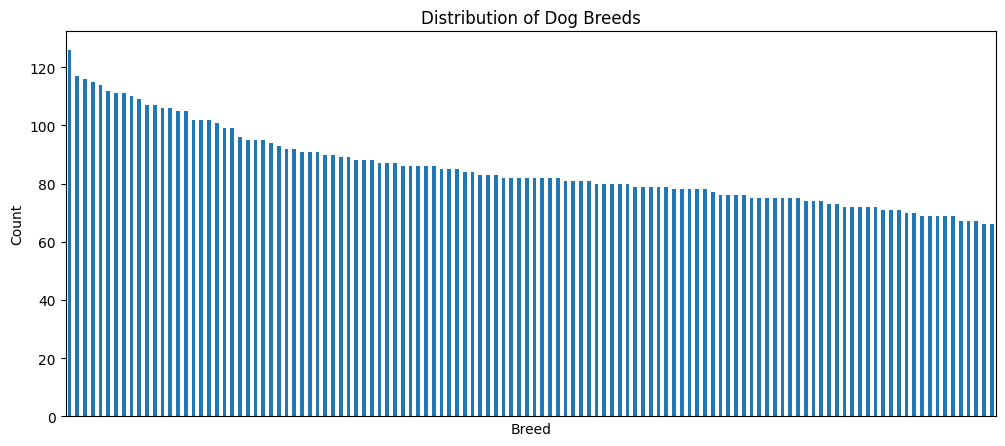

In [ ]:
# Number of unique breeds
print(f"Number of unique breeds: {labels_df['breed'].nunique()}")

# Plot breed distribution
plt.figure(figsize=(12, 5))
labels_df['breed'].value_counts().plot(kind='bar')
plt.title('Distribution of Dog Breeds')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks([], [])
plt.show()


**One-Hot Encoding Labels**

Since the output variable (dog breed) is categorical, we convert it to one-hot encoded vectors using `LabelBinarizer`. This format is suitable for training a neural network with categorical crossentropy loss.


In [ ]:
from sklearn.preprocessing import LabelBinarizer

# One-hot encode breed labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_df['breed'])

# Save breed names
breed_names = lb.classes_
print("Labels shape:", labels.shape)
print("Example label (one-hot):", labels[0])


Labels shape: (10222, 120)
Example label (one-hot): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


**Preprocessing Images**

we use Keras' ImageDataGenerator with flow_from_dataframe. This allows efficient image preprocessing and augmentation during training. It reads images directly from disk in batches, preventing memory issues.

**Splitting into Train and Validation Sets**

To evaluate our model’s performance during training, we split the dataset into:
- **Training Set (80%)**: Used to train the CNN.
- **Validation Set (20%)**: Used to evaluate the model’s performance on unseen data.


In [ ]:
!cp -r /content/drive/MyDrive/dog_breed_data/train /content/
!cp -r /content/drive/MyDrive/dog_breed_data/test /content/


In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels_df['id'] = labels_df['id'].apply(lambda x: x + ".jpg")

# Split into train and validation
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['breed'], random_state=42)

train_dir = '/content/drive/MyDrive/dog_breed_data/train'

# Initialize generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='breed',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='id',
    y_col='breed',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


Selected MobileNetV2 as the base model for transfer learning due to its efficiency and strong performance on resource-constrained devices. Froze the base layers initially to retain pretrained ImageNet features, and added a lightweight classification head consisting of a GAP layer, dropout, and softmax output over 120 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(120, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Trained the classification head with the base model frozen to avoid disturbing pretrained features. This helps the top layers learn dataset-specific patterns first before fine-tuning the backbone.


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 86s 247ms/step - accuracy: 0.2144 - loss: 3.7291 - val_accuracy: 0.6386 - val_loss: 1.4419
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 64s 205ms/step - accuracy: 0.6877 - loss: 1.2130 - val_accuracy: 0.7012 - val_loss: 1.1054
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 81s 201ms/step - accuracy: 0.7743 - loss: 0.8353 - val_accuracy: 0.7159 - val_loss: 0.9844
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 200ms/step - accuracy: 0.8261 - loss: 0.6356 - val_accuracy: 0.7218 - val_loss: 0.9255
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 200ms/step - accuracy: 0.8457 - loss: 0.5477 - val_accuracy: 0.7413 - val_loss: 0.9007
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 200ms/step - accuracy: 0.8836 - loss: 0.4579 - val_accuracy: 0.7413 - val_loss: 0.8850
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 198ms/step - accuracy: 0.9072 - loss: 0.3843 - val_accuracy: 0.7394 - val_loss: 0.8762
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 197ms/step - accuracy: 0.9112 - loss: 0

Unfroze the base model and continued training at a lower learning rate to fine-tune all layers jointly. This improves overall accuracy by allowing the model to adjust deeper convolutional filters based on dog breed-specific features.


In [ ]:
# Unfreeze the base model
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 128s 307ms/step - accuracy: 0.7401 - loss: 0.8948 - val_accuracy: 0.7384 - val_loss: 0.8660
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 66s 257ms/step - accuracy: 0.8278 - loss: 0.5771 - val_accuracy: 0.7384 - val_loss: 0.8565
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 66s 258ms/step - accuracy: 0.8712 - loss: 0.4481 - val_accuracy: 0.7418 - val_loss: 0.8424
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 56s 219ms/step - accuracy: 0.8895 - loss: 0.3881 - val_accuracy: 0.7443 - val_loss: 0.8210
Epoch 5/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 64s 251ms/step - accuracy: 0.8999 - loss: 0.3425 - val_accuracy: 0.7521 - val_loss: 0.8043


Saved the final trained model to Drive. This `.h5` file will be used later in the backend integration phase via FastAPI, as per assignment requirements.


In [ ]:
model.save('/content/drive/MyDrive/dog_breed_data/cnn_model.h5')


Loaded test images, resized them to match the model input size, and used the trained model to predict softmax probabilities for each breed. Predictions were stored for submission.


In [ ]:
import os
from tensorflow.keras.preprocessing import image

test_dir = '/content/drive/MyDrive/dog_breed_data/test'
test_images = sorted(os.listdir(test_dir))

# Prepare list to store predictions
predictions = []

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    predictions.append(pred[0])


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Created a submission file in the expected Kaggle format, with image IDs and predicted probabilities for all 120 classes.


In [ ]:
import pandas as pd

pred_df = pd.DataFrame(predictions, columns=breed_names)
pred_df.insert(0, "id", [f[:-4] for f in test_images])

# Save to CSV
submission_path = '/content/drive/MyDrive/dog_breed_data/submission.csv'
pred_df.to_csv(submission_path, index=False)

print("Submission file saved to:", submission_path)
